In [7]:
import autograd.numpy as np

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import matplotlib.pyplot as plt
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

from numpy.fft import *
import matplotlib.style as style 
style.use('ggplot')

# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Extract data and denoise

Extract a sample set to use for training data, and denoise it with a threshold filter.

In [2]:
data = np.loadtxt('../data/test.csv',delimiter = ' ')[0]

In [3]:
#function to filter out frequencies in signal that are above the threshold
def filter_signal(signal, threshold=5e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

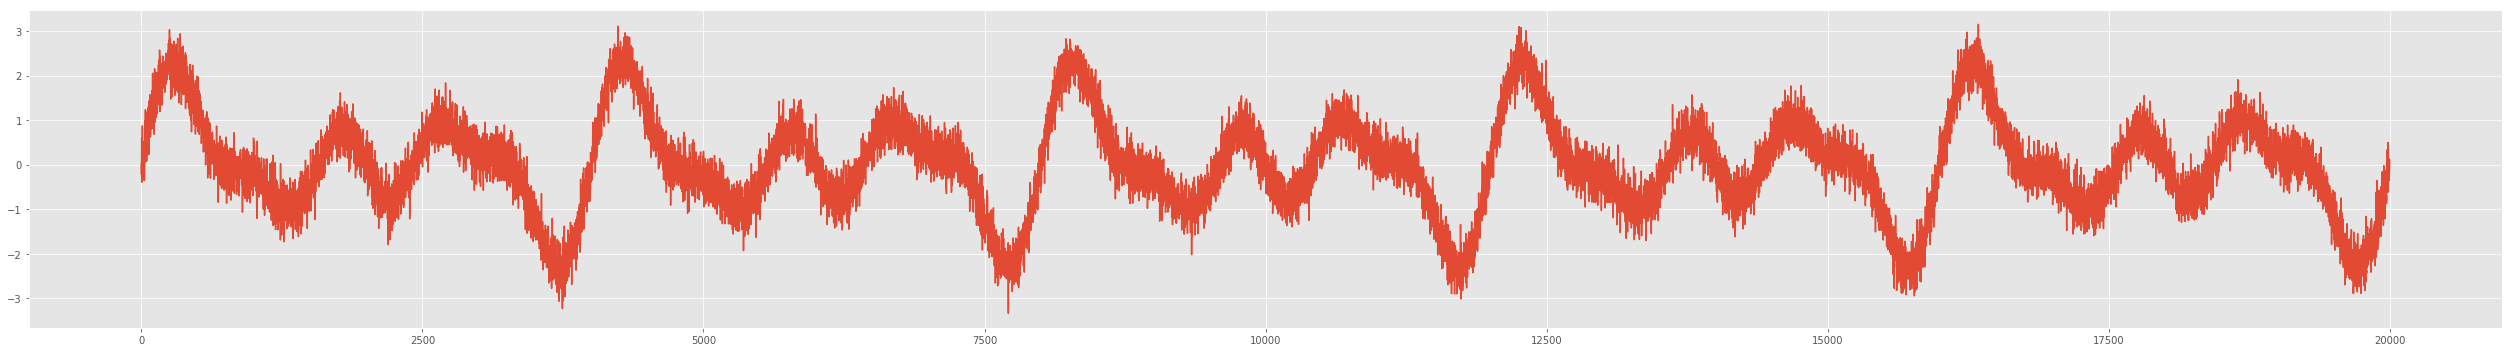

In [4]:
#Plot of a clean window of data
clean_data = data[:20000]

plt.figure(figsize=(35,5))
plt.plot(clean_data)
plt.show()

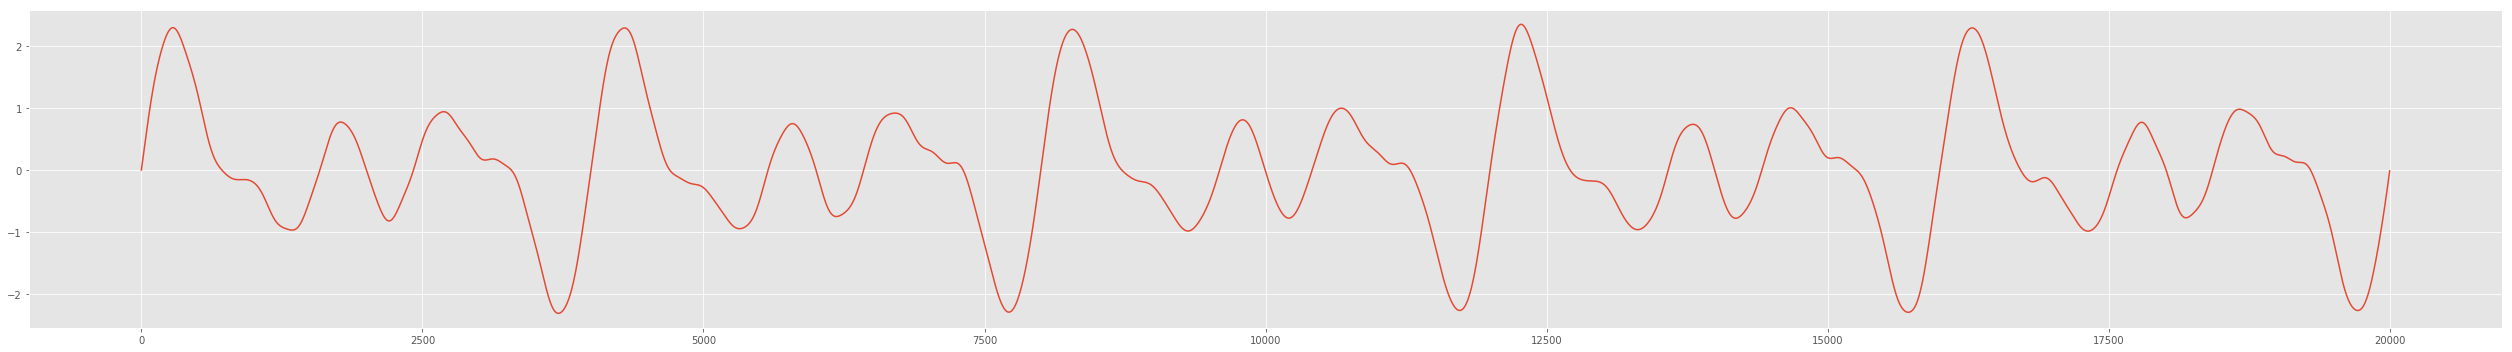

In [5]:
# Plot cleaned data by filtering out all frequencies greater than the threshold
X = filter_signal(clean_data)

plt.figure(figsize=(35,5))
plt.plot(X)
plt.show()

## Step 2: Creating Training Data

The approach here is to produce input & output data for supervised learning.
The clean signal for 5 cycles is the input data (variable X), and the output data (variable Y) is a counter for the number of cycles that starts at zero and increases linearly to one at the end of the first cycle and continues to increase linearly with the number of cycles.

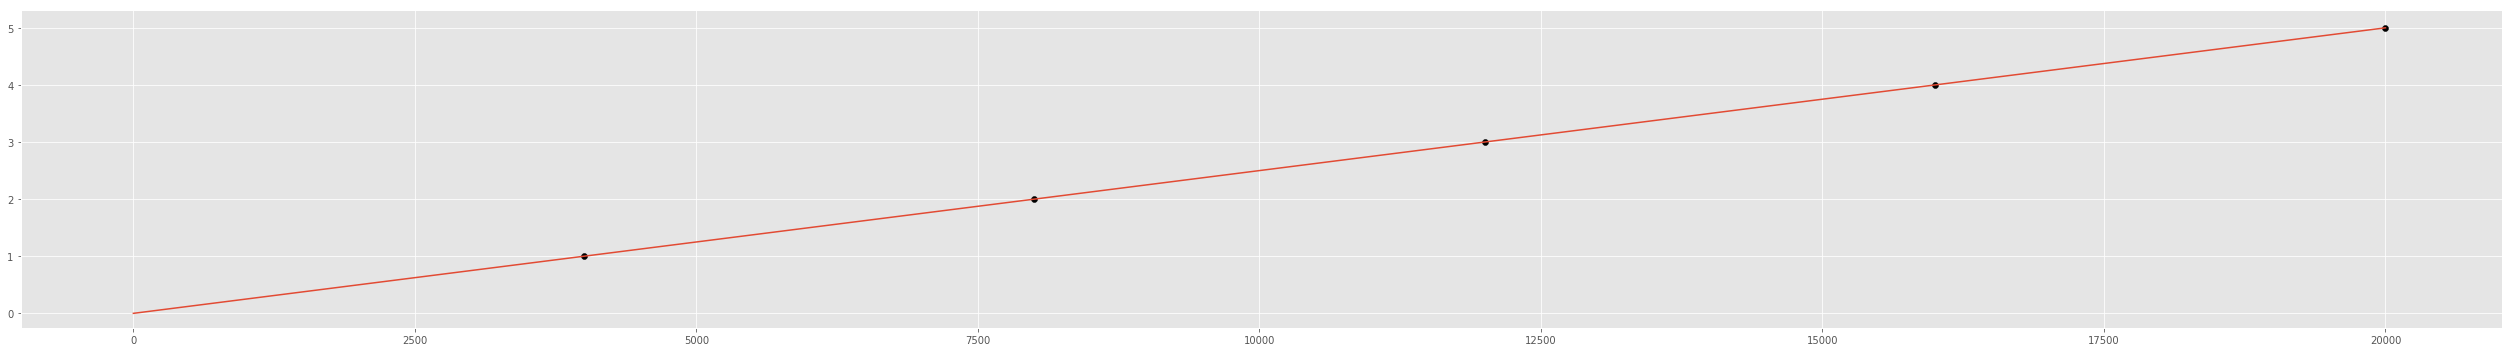

In [27]:
scaler = MinMaxScaler(feature_range=(0, 5)) #min max scaler 
Y = scaler.fit_transform(np.asarray([i for i in range(len(clean_data)+1)]).reshape(-1,1)) #rescale between 0 and 5

#plot the output with points for ints - represents the end of a cycle and an increment in count
plt.figure(figsize=(35,5))
plt.plot(Y)
plt.scatter([4000,4000*2,4000*3,4000*4,4000*5],[1,2,3,4,5],color='Black')
plt.show()